# Workflow for MaxwellLink Socket Interface: Spontaneous Emission of TLS

Here, we introduce the two-level system (TLS) spontaneous emission tutorial using `maxwelllink.Molecule` and a TCP socket.

## 1. Setting up the socket communication layer

Using the TCP socket requires to set the `hostname` and `port number`. In local machines, we can use the helper function `get_available_host_port()` from **MaxwellLink** to obtain these two pieces of information. Then, we initialize a `SocketHub` instance to provide the socket communication in **MaxwellLink**.

In [1]:
import numpy as np
import maxwelllink as mxl
from maxwelllink import sockets as mxs

try:
    import meep as mp
except ImportError as exc:  
    raise RuntimeError(
        "Meep is required for this tutorial."
        "Install via conda: conda install -c conda-forge pymeep=*=mpi_mpich_*"
    ) from exc

host, port = mxs.get_available_host_port()
hub = mxl.SocketHub(host=host, port=port, timeout=10.0, latency=1e-5)

print(f"SocketHub listening on {host}:{port}")


Using MPI version 4.1, 1 processes
SocketHub listening on 127.0.0.1:64747


## 2. Bind Molecule and EM solver to the SocketHub

Then, we create a `Molecule` instance to define the information of this molecule in the EM simulation environment, including the `center`, `size`, `sigma` (width of the molecular polarization distribution), and `dimensions`. 

We also need to setup the EM solver (**MEEP**) using `mxl.MeepSimulation`. This class is a wrapper of the `meep.Simulation` object with extended parameters for **MaxwellLink**.

In [2]:
molecule = mxl.Molecule(
    hub=hub,
    center=mp.Vector3(0, 0, 0),
    size=mp.Vector3(1, 1, 1),
    sigma=0.1,
    dimensions=2,
)

sim = mxl.MeepSimulation(
    hub=hub,
    molecules=[molecule],
    cell_size=mp.Vector3(8, 8, 0),
    boundary_layers=[mp.PML(3.0)],
    resolution=10,
    time_units_fs=0.1,
)


[Init Molecule] Under socket mode, registered molecule with ID 0


 ######### MaxwellLink Units Helper #########
 MEEP uses its own units system, which is based on the speed of light in vacuum (c=1), 
 the permittivity of free space (epsilon_0=1), and the permeability of free space (mu_0=1). 
 To couple MEEP with molecular dynamics, we set [c] = [epsilon_0] = [mu_0] = [hbar] = 1. 
 By further defining the time unit as 1.00E-01 fs, we can fix the units system of MEEP (mu).

 Given the simulation resolution = 10,
 - FDTD dt = 5.00E-02 mu (0.5/resolution) = 5.00E-03 fs
 - FDTD dx = 1.00E-01 mu (1.0/resolution) = 3.00E+00 nm
 - Time [t]: 1 mu = 1.00E-01 fs = 4.13E+00 a.u.
 - Length [x]: 1 mu = 3.00E+01 nm
 - Angular frequency [omega = 2 pi * f]: 1 mu = 6.5851E+00 eV = 2.4200E-01 a.u.
 - Electric field [E]: 1 mu = 6.65E+07 V/m = 1.29E-04 a.u.
 Hope this helps!
 ############################################




## 3. Python way to lunch `mxl_driver` on a separate terminal

Generally, using the Socket Interface requires to launch the EM simulation in one terminal and then start the molecular driver simulation in a separate terminal. To avoid openning a second terminal, below we introduce a python helper function `launch_tls_driver(...)`, which will launch `mxl_driver` from Python (so we can stay within this notebook to finish this tutorial). 

Here, we set the TLS starting at the initial excited-state population of 1e-4.

Immediately after launching this driver in the background, we run the simulation using `sim.run(...)`. This function is a wrapper of the `meep.Simulation.run(...)` function, which can accept user-defined step functions.

In [3]:
import shlex
import shutil
import subprocess
import time


def launch_tls_driver(host: str, port: int, sleep_time: float = 0.5):
    executable = shutil.which('mxl_driver')
    if executable is None:
        raise RuntimeError('mxl_driver executable not found in PATH.')
    cmd = (
        f"{executable} --model tls --address {host} --port {port}"
        f' --param "omega=0.242, mu12=187, orientation=2, pe_initial=1e-4"'
    )
    print('Launching TLS driver via subprocess...')
    print('If you prefer to run it manually, execute:')
    print('  ' + cmd)
    argv = shlex.split(cmd)
    proc = subprocess.Popen(argv)
    time.sleep(sleep_time)
    return proc

launch_tls_driver(host, port)

sim.run(until=90)

hub.stop()

Launching TLS driver via subprocess...
If you prefer to run it manually, execute:
  /Users/taoli/miniforge3/envs/mxl/bin/mxl_driver --model tls --address 127.0.0.1 --port 64747 --param "omega=0.242, mu12=187, orientation=2, pe_initial=1e-4"
-----------
Initializing structure...
time for choose_chunkdivision = 9.7e-05 s
Working in 2D dimensions.
Computational cell is 8 x 8 x 0 with resolution 10
time for set_epsilon = 0.003608 s
-----------
[SocketHub] CONNECTED: mol 0 <- 127.0.0.1:64750
[initialization] Time step in atomic units: 0.20670686667500004
[initialization] Assigned a molecular ID: 0
init TLSModel with dt = 0.206707 a.u., molecule ID = 0
[initialization] Finished initialization for molecular ID: 0
run 0 finished at t = 90.0 (1800 timesteps)
Received STOP, exiting
[SocketHub] DISCONNECTED: mol 0 from 127.0.0.1:64750


## 4. Retrive molecular simulation data

After the simulation, we can retrive molecular simulation data from `molecule.additional_data_history`, a Python list which stores the molecular information sent from the driver code at each step of the simulation.

In [4]:
population = np.array([entry["Pe"] for entry in molecule.additional_data_history])
time_au = np.array([entry["time_au"] for entry in molecule.additional_data_history])

print(f"Collected {population.size} samples.")

Collected 1801 samples.


## 5. Compare with the Analytical Golden-Rule Decay

Finally, we can compare this numerical simulation with analytical golden-rule rate calculations. 

Although the EM field is described entirely classically, because the initial TLS excited-state population is small, our semiclassical simulation of TLS spontaneous emission exactly agree with quantum golden-rule calculations. 

This agreement between semiclassical and quantum electrodynamics has been identified more than half a century ago by Jaynes (https://ieeexplore.ieee.org/document/1443594). Recent numerical calculations of semiclassical electrodynamics also validate this agreement (https://doi.org/10.1103/PhysRevA.97.032105).

std_dev=2.717e-03, max_abs_diff=7.413e-03


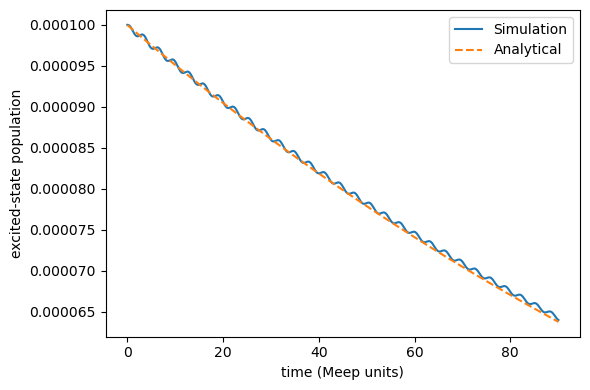

In [5]:
time_fs = time_au * 0.02418884254
time_meep = time_fs / 0.1
initial = population[0]
dipole_moment = 0.1
frequency = 1.0
gamma = dipole_moment**2 * frequency**2 / 2.0
reference = np.exp(-time_meep * gamma) / (
    np.exp(-time_meep * gamma) + (1.0 - initial) / initial
)

std_rel = np.std(population - reference) / initial
max_rel = np.max(np.abs(population - reference)) / initial
print(f"std_dev={std_rel:.3e}, max_abs_diff={max_rel:.3e}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(time_meep, population, label="Simulation")
plt.plot(time_meep, reference, label="Analytical", linestyle="--")
plt.xlabel("time (Meep units)")
plt.ylabel("excited-state population")
plt.legend()
plt.tight_layout()
plt.show()
